# Week 2: Data Preprocessing and Linear Basis Function Expansions

# Lecture 3

## Example: Air Pollution

We will next work on a somewhat extensive example with a real dataset. It will be a pretty realistic problem because the data is not quite pristine and will require some preprocessing before it can be modeled well.

To facilitate that, we import some libraries and functions.

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

For this example, we will use the Beijing Multi-Site Air-Quality Data Data Set dataset$^1$ available from the [UC Irvine Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Beijing+Multi-Site+Air-Quality+Data). It is a hourly data set considers 6 main air pollutants and 6 relevant meteorological variables at multiple sites in Beijing.

[1] Zhang, S., Guo, B., Dong, A., He, J., Xu, Z. and Chen, S.X. (2017) Cautionary Tales on Air-Quality Improvement in Beijing. *Proceedings of the Royal Society A*, Volume 473, No. 2205. https://doi.org/10.1098/rspa.2017.0457

The dataset includes a number of variables associated with time, weather, and location: the year, month, day, hour, temperature, pressure, dew point, precipitation, wind direction, wind speed, and station name.

The dataset also includes air pollutant levels for: fine inhalable particulate matter with diameter $\leq 2.5\,\mu$m (PM$_{2.5}$), inhalable particles with diameter $\leq 10\, \mu$m (PM$_{10}$), sulfur dioxide (SO$_2$), nitrogen dioxide (NO$_2$), carbon monoxide (CO), and ozone (O$_3$).

We will try to predict these pollution levels based the time, weather, and location variables.

This dataset is not as neat as the US high school graduation data: there are numerical variables, but there are a few new wrinkles:

* Some variables are text
* There is missing numbers in the dataset
* There is a variable that simply indexes the data

All of these issues would prevent us from using ordinary least squares, so we need to solve these issues. In most applied problems, there are similar issues that must be managed before you can do much machine learning.

#### Cleaning/Preprocessing the Data

First, we must **clean** the data (manipulate it into a data matrix we can use for machine learning). The data is stored in 12 separate comma-separated value (CSV) files, so we will use the `glob` library to iterate through the files and use the `pandas` library to store each as a dataframe and then concatenate them into one big dataframe.

In [8]:
import glob

# import all the files in data/PRSA
dataFiles = glob.glob('../data/PRSA/*')

# empty list to store the data
data = []

# iterate through files, read files
for file in dataFiles:
    # convert file to dataframe and add it to the list
    data.append(pd.read_csv(file, sep = ','))
    
# concatenate all the dataframes into one
data = pd.concat(data)

# display the data
data

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
0,1,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,Aotizhongxin
1,2,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,N,4.7,Aotizhongxin
2,3,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,NNW,5.6,Aotizhongxin
3,4,2013,3,1,3,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,NW,3.1,Aotizhongxin
4,5,2013,3,1,4,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,N,2.0,Aotizhongxin
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35059,35060,2017,2,28,19,11.0,32.0,3.0,24.0,400.0,72.0,12.5,1013.5,-16.2,0.0,NW,2.4,Wanshouxigong
35060,35061,2017,2,28,20,13.0,32.0,3.0,41.0,500.0,50.0,11.6,1013.6,-15.1,0.0,WNW,0.9,Wanshouxigong
35061,35062,2017,2,28,21,14.0,28.0,4.0,38.0,500.0,54.0,10.8,1014.2,-13.3,0.0,NW,1.1,Wanshouxigong
35062,35063,2017,2,28,22,12.0,23.0,4.0,30.0,400.0,59.0,10.5,1014.4,-12.9,0.0,NNW,1.2,Wanshouxigong


Next, we can use pandas to drop unimportant variables:

* Drop the '**No**' column with `drop()` since it just stores an index that has no physical significance.
* Drop rows with empty values with `dropna()`.

In [9]:
# drop the 'No' column
data = data.drop(columns = ['No'])

# drop rows with missing data
data = data.dropna()

# display the data
data

,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
0,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,Aotizhongxin
1,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,N,4.7,Aotizhongxin
2,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,NNW,5.6,Aotizhongxin
3,2013,3,1,3,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,NW,3.1,Aotizhongxin
4,2013,3,1,4,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,N,2.0,Aotizhongxin
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35059,2017,2,28,19,11.0,32.0,3.0,24.0,400.0,72.0,12.5,1013.5,-16.2,0.0,NW,2.4,Wanshouxigong
35060,2017,2,28,20,13.0,32.0,3.0,41.0,500.0,50.0,11.6,1013.6,-15.1,0.0,WNW,0.9,Wanshouxigong
35061,2017,2,28,21,14.0,28.0,4.0,38.0,500.0,54.0,10.8,1014.2,-13.3,0.0,NW,1.1,Wanshouxigong
35062,2017,2,28,22,12.0,23.0,4.0,30.0,400.0,59.0,10.5,1014.4,-12.9,0.0,NNW,1.2,Wanshouxigong


#### Converting a Categorical Variable to One-Hot

Note the number of datapoints went from 420768 to 382168, a loss of about 9\% of the data, due to some data being incomplete. Simply dropping datapoints can sometimes bias the model, but this is a relatively small amount of data, so it should not be a big problem.

The next problem we have is that the **station** variable is not numerical but is rather categorical, representing the site where the datapoint was measured. This does not work with ordinary least squares. We could delete them from the dataset as well, but these sites are in different parts of the city which may experience different pollution patterns, so this information may help the model make predictions.

One way to deal with categorical variables in machine learning problems is to convert them to **one-hot vectors** which are standard basis vectors of $\mathbb{R}^m$ where $m$ is the number of categories. In other words, they are made up of all 0s except for one 1, representing the one category in the datapoint.

Luckily, `Pandas` has a `get_dummies()` function, which does this conversion for us!

In [10]:
# convert the 'station' column to binary variables
data = pd.get_dummies(data, columns = ['station'])

# display the data
data

,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,...,station_Dingling,station_Dongsi,station_Guanyuan,station_Gucheng,station_Huairou,station_Nongzhanguan,station_Shunyi,station_Tiantan,station_Wanliu,station_Wanshouxigong
0,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,77.0,...,False,False,False,False,False,False,False,False,False,False
1,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,77.0,...,False,False,False,False,False,False,False,False,False,False
2,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,73.0,...,False,False,False,False,False,False,False,False,False,False
3,2013,3,1,3,6.0,6.0,11.0,11.0,300.0,72.0,...,False,False,False,False,False,False,False,False,False,False
4,2013,3,1,4,3.0,3.0,12.0,12.0,300.0,72.0,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35059,2017,2,28,19,11.0,32.0,3.0,24.0,400.0,72.0,...,False,False,False,False,False,False,False,False,False,True
35060,2017,2,28,20,13.0,32.0,3.0,41.0,500.0,50.0,...,False,False,False,False,False,False,False,False,False,True
35061,2017,2,28,21,14.0,28.0,4.0,38.0,500.0,54.0,...,False,False,False,False,False,False,False,False,False,True
35062,2017,2,28,22,12.0,23.0,4.0,30.0,400.0,59.0,...,False,False,False,False,False,False,False,False,False,True


Note the station variable has been replaced with a binary variable for each station. In all, we lost 1 column (**station**) and gained 12 more, **station_(station name)**, resulting in 28 total columns.

#### Wind Direction

The last problem we see is the wind direction column:

In [11]:
data['wd']

0        NNW
1          N
2        NNW
3         NW
4          N
        ... 
35059     NW
35060    WNW
35061     NW
35062    NNW
35063    NNE
Name: wd, Length: 382168, dtype: object

These values in the **wd** column represent the wind speed. So, why not simply replace them with one-hot vectors like the **station** column?

We could, but this obscures some information in the data. These are stored as categorical variables, but they correspond to angles. If we used one-hot vectors, we may lose that physical structure.

Another option is to simply convert them to angles and store them in radians as $\theta=0$, $\frac{\pi}{8}$, $\frac{2\pi}{8}$, ..., $\frac{15\pi}{8}$. (In reality, different angles are possible, but the original data was rouded to these values.) This leads to another problem: here, it will appear to the algorithm that, for example, the difference between an angles of $0$ and $\frac{15\pi}{8}$ will be much greater than the difference between angles of $0$ and $\pi$, which is not quite right in this context.

A better solution is to store the wind direction as a vector on the unit circle as $(\cos(\theta), \sin(\theta))$. So, let's write a simple function that converts radian measures to this vector.

In [12]:
# convert an angle to a list of unit circle coordinates
def unitCircle(angle):
    return [np.cos(angle), np.sin(angle)]

Then, let's make a dictionary that maps each direction to the appropriate angle

In [13]:
# list all wind directions, along the unit circle
directions = ['E', 'ENE', 'NE', 'NNE', 'N', 'NNW', 'NW', 'WNW', 'W', 'WSW', 'SW', 'SSW', 'S', 'SSE', 'SE', 'ESE']

# make a dictionary associating each direction with coordinates on the unit circle 
directionDict = {direction : unitCircle(i*np.pi/8) for (i, direction) in enumerate(directions)}

# create a dataframe from the dictionary
directionDf = pd.DataFrame.from_dict(directionDict, orient = 'index', columns = ['unitX', 'unitY'])

# display the dataframe
directionDf

,unitX,unitY
E,1.000000e+00,0.000000e+00
ENE,9.238795e-01,3.826834e-01
NE,7.071068e-01,7.071068e-01
NNE,3.826834e-01,9.238795e-01
N,6.123234e-17,1.000000e+00
NNW,-3.826834e-01,9.238795e-01
NW,-7.071068e-01,7.071068e-01
WNW,-9.238795e-01,3.826834e-01
W,-1.000000e+00,1.224647e-16
WSW,-9.238795e-01,-3.826834e-01


Our goal will be to add **unitX** and **unitY** columns to our `data` dataframe, map the existing **wd** value to the appropriate $x$ and $y$ coordinates, and delete the **wd** column.

`pandas` has the `join` function to take the dataframe we just created to do just this mapping.

In [14]:
# join the direction dataframe with the data, mapping directions to unit circle coordinates
data = data.join(directionDf, on = 'wd')

# drop the wind direction column
data = data.drop(columns = ['wd'])

# display the data
data

,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,...,station_Guanyuan,station_Gucheng,station_Huairou,station_Nongzhanguan,station_Shunyi,station_Tiantan,station_Wanliu,station_Wanshouxigong,unitX,unitY
0,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,77.0,...,False,False,False,False,False,False,False,False,-3.826834e-01,0.923880
1,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,77.0,...,False,False,False,False,False,False,False,False,6.123234e-17,1.000000
2,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,73.0,...,False,False,False,False,False,False,False,False,-3.826834e-01,0.923880
3,2013,3,1,3,6.0,6.0,11.0,11.0,300.0,72.0,...,False,False,False,False,False,False,False,False,-7.071068e-01,0.707107
4,2013,3,1,4,3.0,3.0,12.0,12.0,300.0,72.0,...,False,False,False,False,False,False,False,False,6.123234e-17,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35059,2017,2,28,19,11.0,32.0,3.0,24.0,400.0,72.0,...,False,False,False,False,False,False,False,True,-7.071068e-01,0.707107
35060,2017,2,28,20,13.0,32.0,3.0,41.0,500.0,50.0,...,False,False,False,False,False,False,False,True,-9.238795e-01,0.382683
35061,2017,2,28,21,14.0,28.0,4.0,38.0,500.0,54.0,...,False,False,False,False,False,False,False,True,-7.071068e-01,0.707107
35062,2017,2,28,22,12.0,23.0,4.0,30.0,400.0,59.0,...,False,False,False,False,False,False,False,True,-3.826834e-01,0.923880


Finally, our data is totally numerical, so we can now fit a regression model!

#### Train and Test Sets

We convert the pollutant columns to a `NumPy` array by applying the `to_numpy()` function to `data`, selecting just the pollutant columns. These are our responses, or $y$ variables in the regression problem, `dataY`. We take the opposite columns to be the data matrix, `dataX`.

Then, we use the `train_test_split` function to randomly assign 75\% of the data to the training set and 25\% to the test set.

In [15]:
pollutants = ['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3']

# pollutants are the responses
dataY = data[pollutants].to_numpy()

# all data except pollutants are predictors
dataX = data.drop(columns = pollutants).to_numpy()

# split the dataset and labels to 75% training set and 25% test set
trainX, testX, trainY, testY = train_test_split(dataX, dataY, test_size = 0.25, random_state = 1)

Let's print the dimensions of our newly created training and test data to see if it makes sense.

In [16]:
print('Training set dimensions')
print(trainX.shape)
print(trainY.shape)

print('\nTest set dimensions')
print(testX.shape)
print(testY.shape)

Training set dimensions
(286626, 23)
(286626, 6)

Test set dimensions
(95542, 23)
(95542, 6)


#### Fitting Separate Models for Each Response Variable

Note that the training set will be quite large (286626 x 286626), which will be difficult with our simple matrix multiplication in the `OrdinaryLeastSquares` class we write, as it is likely to lead to overflows, so let's use the optimized `LinearRegression` class built into the popular `scikit-learn` library and predict each pollutant separately. If you are interested in linear algebra, it is good to know it uses singular value decomposition (SVD).

In [17]:
# import the linear regression model
from sklearn.linear_model import LinearRegression

# instantiate an OLS model
model = LinearRegression()

for i in range(trainY.shape[1]):
    # choose the pollutant
    print('\n==================== Modeling', pollutants[i], 'pollution =====================')

    # fit the model to the training data (find the beta parameters)
    model.fit(trainX, trainY[:, i])

    # return the predicted outputs for the datapoints in the training set
    trainPredictions = model.predict(trainX)

    # print the coefficient of determination r^2
    print('The r^2 score is', model.score(trainX, trainY[:, i]))

    # print quality metrics
    print('The mean absolute error on the training set is', mean_absolute_error(trainY[:, i], trainPredictions))
    
    # print the beta values
    print('The theta values are', np.round(model.coef_, 2))

    # return the predicted outputs for the datapoints in the test set
    predictions = model.predict(testX)

    # print quality metrics
    print('The mean absolute error on the test set is', mean_absolute_error(testY[:, i], predictions))


==================== Modeling PM2.5 pollution =====================
The r^2 score is 0.23510056982521443
The mean absolute error on the training set is 50.44524417765653
The theta values are [ -1.63  -1.33   0.     1.4   -6.03  -1.38   3.78  -4.81  -2.93   1.
  -5.7  -10.36   8.58   1.85   3.08 -18.2    6.82   2.71   3.83   0.57
   5.83   8.89 -17.08]
The mean absolute error on the test set is 50.26149605007199

==================== Modeling PM10 pollution =====================
The r^2 score is 0.1608831884249322
The mean absolute error on the training set is 60.58794671634842
The theta values are [ -2.95  -1.23   0.3    1.71  -5.89  -2.52   2.82  -5.94  -1.11   5.08
 -11.56 -21.97  11.65   4.52  11.63 -24.54   7.82  -0.21   4.36   4.07
   9.15   8.82 -19.96]
The mean absolute error on the test set is 60.539019940236244

==================== Modeling SO2 pollution =====================
The r^2 score is 0.2654229323660171
The mean absolute error on the training set is 11.99922464993692

#### Fitting a Multivariate Regression Model

The `OrdinaryLeastSquares` class we wrote was for multiple regression (multiple inputs) but not multivariate regression (multiple outputs). We will again use the `LinearRegression` class from `scikit-learn`.

In [18]:
# instantiate an OLS model
model = LinearRegression()

# fit the model to the training data (find the beta parameters)
model.fit(trainX, trainY)

# return the predicted outputs for the datapoints in the training set
trainPredictions = model.predict(trainX)

# print the coefficient of determination r^2
print('The r^2 score is', model.score(trainX, trainY))

# print quality metrics
print('The mean absolute error on the training set is', mean_absolute_error(trainY, trainPredictions))

# return the predicted outputs for the datapoints in the test set
predictions = model.predict(testX)

# print the theta values
thetas = [np.round(row, 2) for row in model.coef_]
for i in range(6):
    print('\nThe theta values for predicting', pollutants[i], 'are\n', thetas[i])

# print quality metrics
print('\nThe mean absolute error on the test set is', mean_absolute_error(testY, predictions))

The r^2 score is 0.31240972133930583
The mean absolute error on the training set is 138.44233663696903

The theta values for predicting PM2.5 are
 [ -1.63  -1.33   0.     1.4   -6.03  -1.38   3.78  -4.81  -2.93   1.
  -5.7  -10.36   8.58   1.85   3.08 -18.2    6.82   2.71   3.83   0.57
   5.83   8.89 -17.08]

The theta values for predicting PM10 are
 [ -2.95  -1.23   0.3    1.71  -5.89  -2.52   2.82  -5.94  -1.11   5.08
 -11.56 -21.97  11.65   4.52  11.63 -24.54   7.82  -0.21   4.36   4.07
   9.15   8.82 -19.96]

The theta values for predicting SO2 are
 [-4.67 -1.28 -0.    0.23 -0.78 -0.2  -0.09 -0.51 -1.76  1.68 -0.34 -3.47
  2.1   1.71 -1.13 -4.76  2.93 -1.64 -1.3   2.66  1.55  2.28 -5.13]

The theta values for predicting NO2 are
 [ -1.64   0.15   0.06   0.63  -2.28  -0.69   0.77  -2.17  -7.41   8.64
  -5.72 -23.06   5.69   7.18   1.95 -22.63   9.45  -4.22   4.5   12.55
   5.67   3.33  -4.44]

The theta values for predicting CO are
 [   1.5    10.29   -2.29   17.04  -95.96  -22.61   

As you might note, there is actually no difference between the models in the last two code blocks. The parameters are the same for each pollutant. The only difference is that we have wholistic measures of quality, which are simply averages of the results from above.

In a sense, the linear regression models are just stacked on one another. It turns out, this is a common situation in machine learning. In fact, neural networks (deep learning) that solve regression problems can be considered as stacked models. The difference is that neural networks allows the responses variable to *share* parameters--so all response variables would be influenced by all of the parameters in the model.

#### Parameter Notation

There is an unfortunate situation common to multidisciplinary fields like machine learning: the norms of notation vary in different subfields and related disciplines.

In particular, the notation for model parameters in machine learning unfortunately depends on the subfield where you are reading--$\beta$ is common in statistical literature on linear regression, $w$ or $\alpha$ and $b$ are common in neural networks and deep learning literature, and $\theta$ is common in numerical mathematics and the wider machine learning literature. As a general rule, be careful to read when the notation is introduced in books or papers. The context may not always make it clear.

Going forward, we will follow the norms of *The Elements of Statistical Learning* by Hastie, et. al., and others and refer to model parameters as $\theta_i$.

### Limitations of Fitting Lines, Planes, and Hyperplanes

So far, we have used linear regression to find the best-fit line ($d=1$), plane ($d=2$), or hyperplane ($d\geq 3$) by ordinary least squares. Mathematically, this means we assumed our regression function was in the form

$$\hat{f}(x_i)=\theta^Tx_i$$

We fit the "best" line/plane/hyperplane by constructing the least squares loss function

$$L(\theta)=\sum\limits_{i=1}^n (f(x_i) - y_i)^2=\|X\theta - y\|^2_2$$

and solving the minimization problem

$$\min\limits_{\theta} L(\theta)$$

which gave us a simple formula for the coefficients,

$$\theta = (X^TX)^{-1}Xy$$

that we implemented and used on a few examples.

In some cases, fitting hyperplanes gave some very good results. However, sometimes these shapes just do not fit well. Examples:

* Predicting hourly temperatures in Melbourne, FL over a span of several days with a line would be a bad idea. It should oscillate as temperatures go down at night and back up in the daytime.

* Predicting the number of COVID cases in the US per day or the value of an investment over time with an interest rate with a line would not work well because we know these things grow exponentially.

* The best-fit pollution model from the example above did not explain most of the variation in the pollution data for most pollutants.

Here, fitting lines or hyperplanes does not work, so there are a number of other least squares linear models for regression that attempt to solve these types of problems that we will study over the next couple of weeks. In general, we need to solve the optimization problem

$$\min\limits_{f,\theta} L(f,\theta)$$

for some loss function $L$ where $\theta$ can once again be any real vector of parameters, but there is a new part: $f$ can have a different structure. Now, without further restrictions, this problem has infinitely many solutions.

Indeed, if you consider $d=1$, then the dataset $(x_1,y_1)$, ..., $(x_n,y_n)$ with distinct $x_i$'s is just some points on the 2D plane, so there are infinitely many functions $f$ that will give $L = 0$ when using the sum of squares loss function.

**Math Note**: Not only are there infinitely many solutions, but the space of functions with 0 loss is actually infinite-dimensional!

We have two main problems here:

1. Sometimes there is no line/plane/hyperplane that maps the inputs to the outputs well
2. The optimization problem has infinitely many solutions when we do not assume $f$ has a particular structure

When we have the first problem, clearly we need to use a different type of function $f$ if we hope to build a good model. With the second problem, there are broadly three classes of remedies in linear regression:

* **Basis function methods** restrict $f$ to be within a pre-defined set of functions linear in the $\theta_i$'s but apply some nonlinear function(s) to the inputs.

* **Kernel regression methods** adjust the loss function $L$ by weighting the sum of errors by localized properties like proximity to nearby training points.

* **Regularization methods** adjust the loss function $L$ by adding terms to the loss function that *penalize* negative characteristics of fitted functions

Many approaches combine more than 1 of these ideas.

## Linear Basis Expansions

These methods replace the function $\hat{f}$ with

$$\hat{f}(x_i)=\theta^Th(x_i) = \sum\limits_{m=0}^M \theta_m h_m(x_i)$$

for some user-selected functions $h_0$, ..., $h_M$ and we denote

$$
h(x_i)=\begin{pmatrix}h_0(x_i)\\
\vdots \\
h_M(x_i)
\end{pmatrix}
$$

Notice that $h$ is a function mapping $\mathbb{R}^d$ to $\mathbb{R}^{M+1}$ for some positive integer $M$.

If $d=1$, some common examples are polynomials of degree $\leq M$ ($h_m(x)=x^m$) or trig functions with different periods. It should not be surprising that these are common if you recall that Taylor polynomials and Fourier sums are good at approximating many functions with finite numbers of terms. Taking logs or exponentials of variables is also common, but the possibilities are endless.

If $d\geq 2$, one common approach is to fit arbitrary polynomials below a certain degree. For example, if we had $x_i=(x_{i1}, x_{i2})$, we could use

$$
\begin{align}
&h_0(x_i) = 1\\
&h_1(x_i) = x_{i1}, h_2(x_i) = x_{i2}\\
&h_3(x_i) = x_{i1}^2, h_4(x_i) = x_{i1}x_{i2}, h_5(x_i) = x_{i2}^2
\end{align}
$$

which would allow us to fit any polynomial of degree $\leq 2$,

$$
\hat{f}(x_i) = \theta_0 + \theta_1x_{i1} + \theta_2x_{i2} + \theta_3x_{i3} + \theta_{11}x_{i1}^2 + \theta_{12}x_{i1}x_{i2} + \theta_{22}x_{i2}^2
$$

Note that, regardless of what the basis functions $h_m$ are, $\hat{f}$ is still linear with respect to the model parameters $\theta_i$. Thus, if we create a modified data matrix,

$$
X_h=\begin{pmatrix}
h_0(x_1) & h_1(x_1) & \cdots &  h_M(x_1)\\
h_0(x_2) & h_1(x_2) & \cdots &  h_M(x_2)\\
\vdots & \vdots & \ddots & \vdots\\
h_0(x_n) & h_1(x_n) & \cdots &  h_M(x_n)
\end{pmatrix}
$$

Then, we can express $\hat{f}$ as

$$\hat{f}(X)=X_h\theta$$

and we can express the loss function as

$$L(\theta) = \left\|X_h\theta-y\right\|_2^2$$

This is the same loss function we minimized before except the known numerical matrix $X$ has changed to this *preprocessed* version $X_h$. Still, it is contant with respect to the model parameters $\theta_i$, so the optimal parametrs will simply change to

$$\theta = \left(X_h^TX_h\right)^{-1}X_h^Ty$$

## 1D Polynomial-Fitting Example

Let's create a linear basis of degree $M$ polynomials. The function will return a function

$$
h(x_i)=\begin{pmatrix}
1\\
x_i\\
x_i^2\\
\vdots \\
x_i^M
\end{pmatrix}
$$

And we will then use it to fit a polynomial.

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

In [20]:
# return polynomial basis functions for degree M and d=1
def univariatePolynomialBasis(M):
    def polynomialM(x):
        # create an empty array
        out = np.array([])
        
        # create the output
        for i in range(M+1):
            # append x^i
            out = np.append(out, x ** i)
        
        # return the polynomial values
        return out
    print(polynomialM)
    
    # return the polynomial function
    return polynomialM

Let's test these basis functions.

In [21]:
# create basis functions for degree-5 polynomials
poly = univariatePolynomialBasis(5)

# plug in a simple value to make sure it works right
print(poly(2))

# apply the polynomial basis to each row of data
print(np.apply_along_axis(poly, 1, np.array([[-1], [2], [3]])))

<function univariatePolynomialBasis.<locals>.polynomialM at 0x000001C54869DB40>
[ 1.  2.  4.  8. 16. 32.]
[[  1.  -1.   1.  -1.   1.  -1.]
 [  1.   2.   4.   8.  16.  32.]
 [  1.   3.   9.  27.  81. 243.]]


Great! It outputs $x_i^0$, $x_i^1$, ..., $x_i^5$, as we hoped.

Next, let's use the scikit-learn implementation of linear regression to try to fit polynomials of different degrees to some simple data. First, we simply apply the basis to the data and plug it into the method.

**Note**: We could lightly modify the linear regression function we wrote last week and use it instead, but it's generally better to use the optimized versions of machine learning algorithms built into scikit-learn when possible. Sometimes, we may want to do something novel, however, in which case it is important to be able to write your own implementations.

1
<function univariatePolynomialBasis.<locals>.polynomialM at 0x000001C509260310>
The theta values are [1.2 0.7]
The r^2 score is 0.9423076923076923
The mean absolute error is 0.20000000000000004
2
<function univariatePolynomialBasis.<locals>.polynomialM at 0x000001C509260C10>
The theta values are [ 1.05714286  0.98571429 -0.07142857]
The r^2 score is 0.9560439560439561
The mean absolute error is 0.17142857142857065
3
<function univariatePolynomialBasis.<locals>.polynomialM at 0x000001C509261480>
The theta values are [ 0.95714286  1.70238095 -0.57142857  0.08333333]
The r^2 score is 0.9752747252747254
The mean absolute error is 0.13714285714285593
4
<function univariatePolynomialBasis.<locals>.polynomialM at 0x000001C509261CF0>
The theta values are [ 1.         -0.08333333  1.875      -0.91666667  0.125     ]
The r^2 score is 1.0
The mean absolute error is 3.552713678800501e-15
5
<function univariatePolynomialBasis.<locals>.polynomialM at 0x000001C509262560>
The theta values are [ 1.  

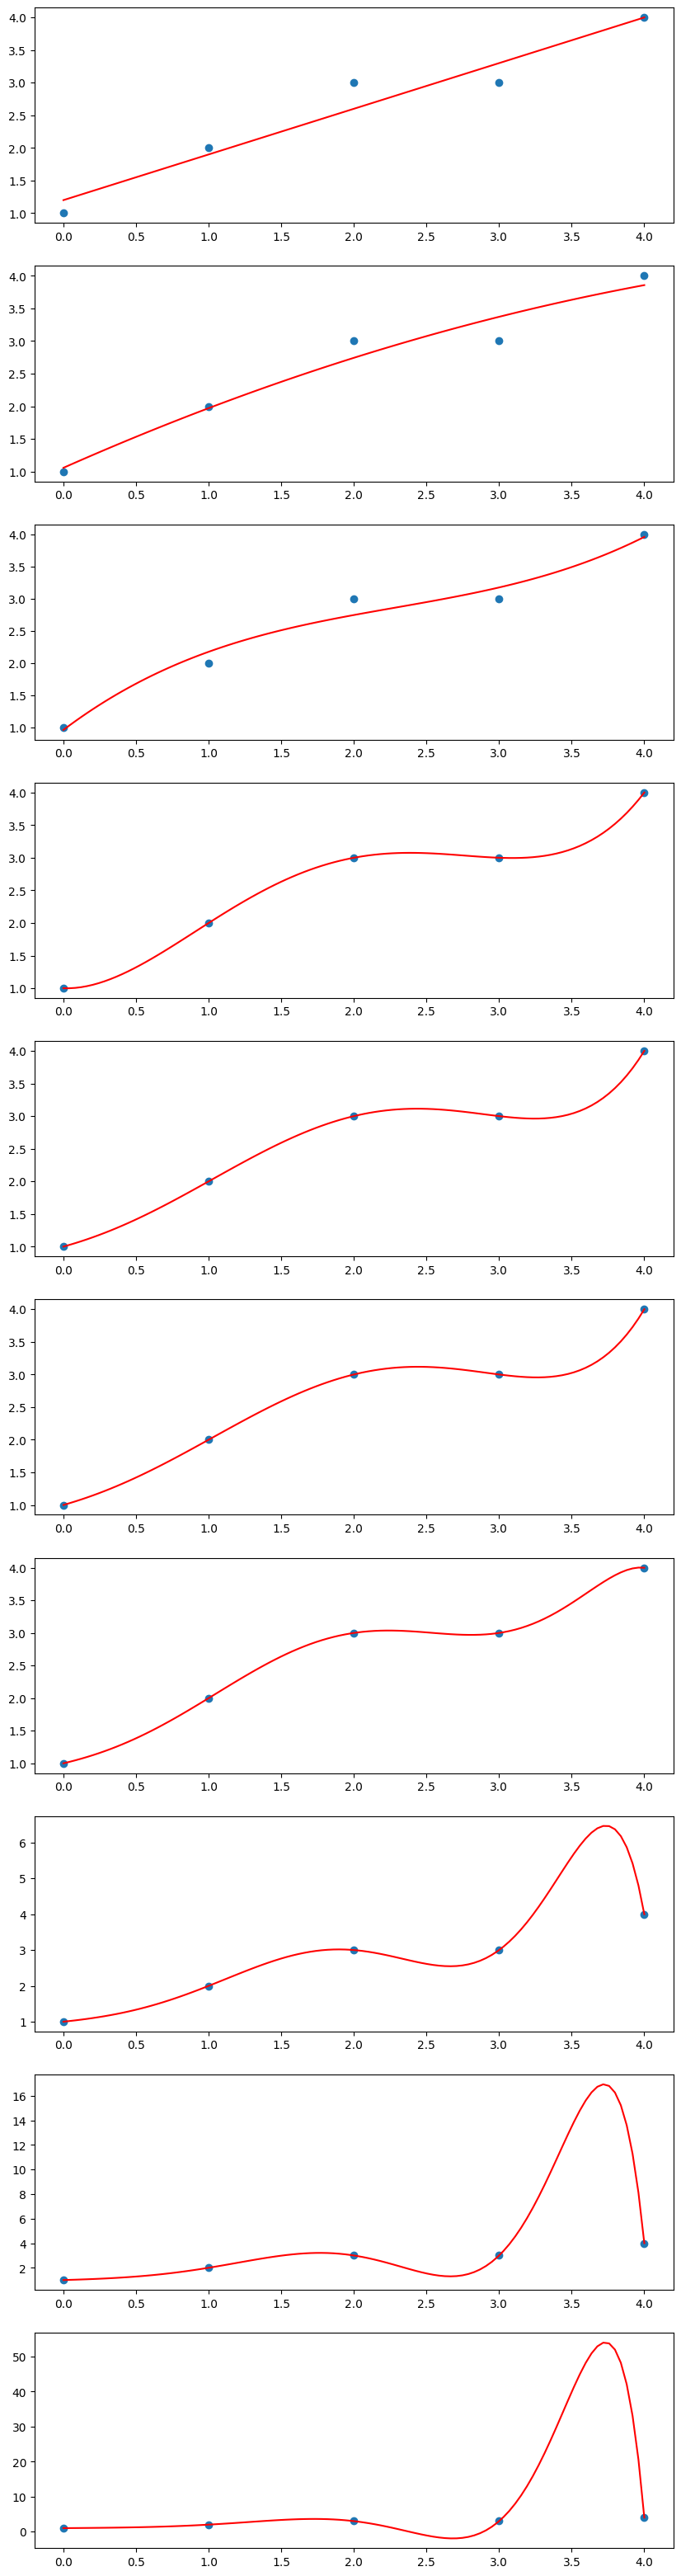

In [22]:
# create some simple data
X = np.array([[0], [1], [2], [3], [4]])
y = np.array([1, 2, 3, 3, 4])

# import scikit-learn's linear regression implementation
from sklearn.linear_model import LinearRegression

# try polynomials up to degree 10
M = 10

# allow multipleplots
fig, axes = plt.subplots(nrows = M, figsize = (10, 4 * M))

# iterate from 1 to M
for i in range(1, M + 1):
    # print the degree
    print(i)
    
    # create the degree i polynomial basis
    poly = univariatePolynomialBasis(i)
    
    # apply the basis functions to the data
    Xh = np.apply_along_axis(poly, 1, X)

    # fit the model
    model = LinearRegression(fit_intercept = False)
    model.fit(Xh, y)
    
    # predict the outputs
    predictions = model.predict(Xh)

    # save the coefficients
    parameters = model.coef_
    print('The theta values are', parameters)

    # plot the training points
    axes[i - 1].scatter(X, y, label = 'Training Data')

    # plot the fitted model with the training data
    xModel = np.atleast_2d(np.linspace(X[0][0],X[-1][0],100)).T
    
    # compute the predicted outputs
    yModel = np.sum(parameters * np.apply_along_axis(poly, 1, xModel), axis = 1)
    
    # plot the model
    axes[i - 1].plot(xModel, yModel, 'r')

    # print quality metrics
    print('The r^2 score is', r2_score(y, predictions))
    print('The mean absolute error is', mean_absolute_error(y, predictions))

We see some interesting behavior. The quality metrics improve as we fit higher degree polynomials: $r^2$ increases more and more each time and the error shrinks. However, the graphs reveal some worrying behavior. The higher-degree models toward the end fit the points perfectly (hence, huge $r^2$ and tiny error), but intuitively, it seems they would doing a *worse* job of making predictions because they have these huge maxima between the last two points.

Here, we see $r^2$ and error are not sufficient for telling us how good a model is likely to perform. This is why it's typical to test models on a test dataset that the model has not seen to check the quality. Let's try this in the next example.

## Shampoo Sales Dataset Example

The data we will use is a small dataset showing the total sales of a certain shampoo by a hair product company per year. Let's take a look at it.

In [23]:
# read the shampoo sales dataset
data = pd.read_csv('../data/shampoo.csv')

# save the targets
y = data['Sales'].to_numpy()

# make a column vector of 0s with n elements
X = np.zeros([y.shape[0], 1])

# convert the vector to (0, 1, 2, ..., n)
X[:,0] = [i for i in range(y.shape[0])]
    
# split the data into train and test sets
(trainX, testX, trainY, testY) = train_test_split(X, y, test_size = 0.25, random_state = 1)

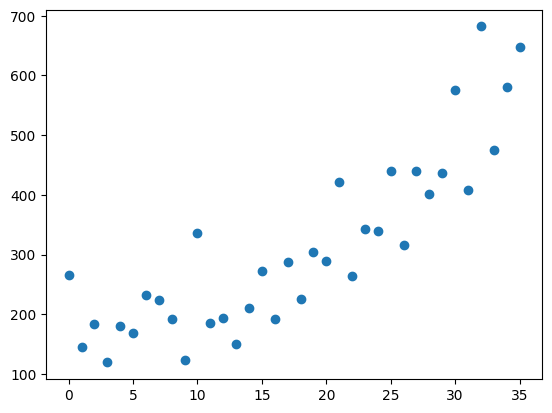

In [24]:
# plot the data
plt.scatter(X, y)

Again, this data is not really linear, but seems to have an exponential growth pattern, although the growth rate is not clear. So, let's fit a curve to it of the form

$$
f(x_i)=\theta_{-M}e^{-x_i}+\theta_{-M+1}e^{-\frac{M-1}{M}x_i}+\cdots+\theta_{-1}e^{-\frac{1}{M}x_i}+\theta_0+\theta_1e^{\frac{1}{M}x_i}+\cdots+\theta_Me^{x_i}
$$

for some natural number $M\in\mathbb{N}$.

First, define the basis.

In [25]:
# return polynomial basis functions for d=1
def expBasis(M):
    def exponential(x):
        # create an empty array
        out = np.array([])
        
        # create the output
        for i in range(-M, M + 1):
            # append x^i
            out = np.append(out, np.exp(x*i/M))
        
        # return the polynomial values
        return out
    
    # return the polynomial function
    return exponential

Next, let's test the basis.

In [26]:
a = expBasis(3)
a(1)

array([0.36787944, 0.51341712, 0.71653131, 1.        , 1.39561243,
       1.94773404, 2.71828183])

This looks okay, as we have three negative exponent terms, the 0 exponent term, and 3 positive exponent terms.

1
[-5.73529080e+01  2.71479442e+02  2.27373675e-13]
The r^2 score is 0.3131448181169426
The mean absolute error on the training set is 90.68169094324192
The mean absolute error on the testing set is 132.352169715052
2
[-2.12428004e+01 -2.03810972e+01  2.43951045e+02  3.53329802e-05
 -6.29718500e-13]
The r^2 score is 0.6356437864259488
The mean absolute error on the training set is 68.97376078023585
The mean absolute error on the testing set is 122.82773755264981
3
[-7.32386582e+00 -7.76144531e+00  6.03542498e+00  2.16880412e+02
  2.40876362e-02 -4.86839609e-07  2.66719979e-12]
The r^2 score is 0.786004824803724
The mean absolute error on the training set is 50.6789498147832
The mean absolute error on the testing set is 88.76902642174427
4
[ 9.55578858e+01  6.76099636e+01 -8.74980035e+00 -1.17521954e+02
  2.14771350e+02  3.10864815e-01 -1.02311066e-04  1.26172175e-08
 -3.83693077e-13]


The r^2 score is 0.8302433678695962
The mean absolute error on the training set is 44.21561819778993
The mean absolute error on the testing set is 60.23974330761618
5
[ 5.28934556e+01  3.63371230e+01  1.45856737e+01 -1.47515223e+01
 -2.88176308e+01  1.81030150e+02  2.71082388e+00 -1.56953651e-02
  4.43938599e-05 -5.30213171e-08  2.17497131e-11]
The r^2 score is 0.8419801539112028
The mean absolute error on the training set is 42.89958551289322
The mean absolute error on the testing set is 71.49195676596997
6
[ 1.51295896e+02  9.76544253e+01  3.34842316e+01 -4.70420465e+01
 -1.36515563e+02 -1.27840293e+02  3.04447918e+02 -1.46174411e+01
  7.18952750e-01 -1.14455951e-02  7.91264570e-05 -2.44068328e-07
  2.74070544e-10]
The r^2 score is 0.8889429399018034
The mean absolute error on the training set is 37.496424941807305
The mean absolute error on the testing set is 222.6780106742988
7
[-1.20839993e+00  6.10434683e-01  4.26339530e+00  9.28272627e+00
  1.78232441e+01  3.14572021e+01  5.4737

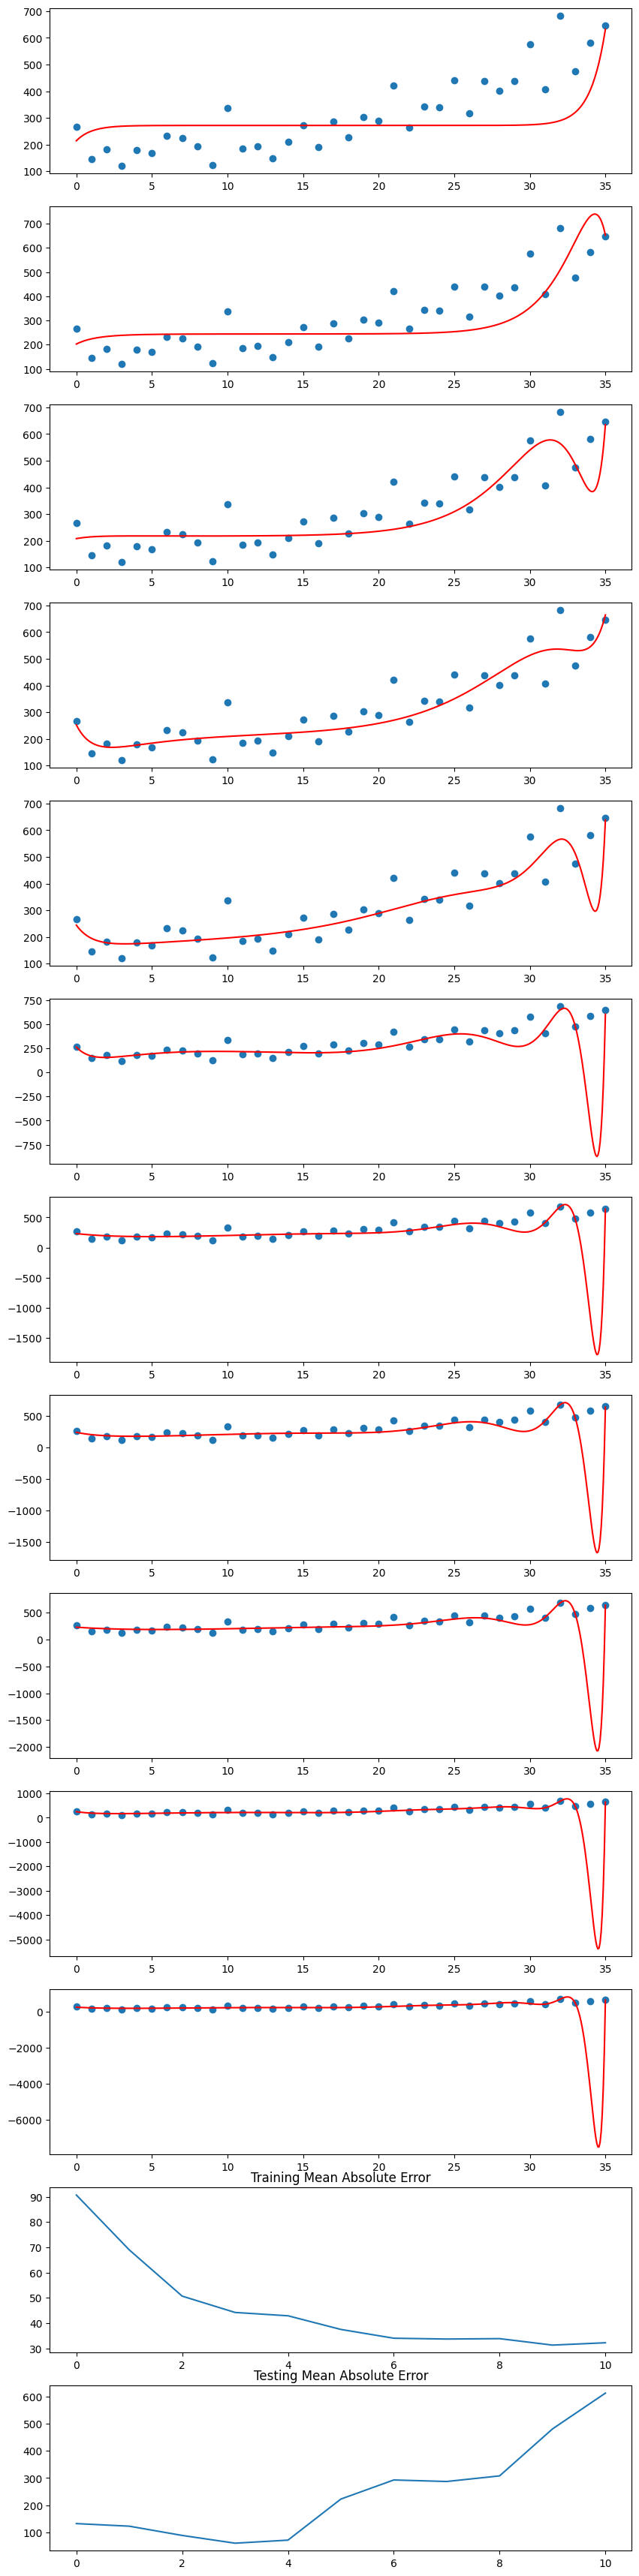

In [27]:
from sklearn.linear_model import LinearRegression

# try basis of up to 20 terms
M = 11

# allow multiple plots
fig, axes = plt.subplots(nrows = M + 2, figsize = (10, 4 * M))

trainMAE = []
testMAE = []

# iterate over each basis size
for i in range(1, M + 1):
    # print basis size
    print(i)
    
    # construct the basis
    exp = expBasis(i)
    
    # apply the basis functions to X
    trainXh = np.apply_along_axis(exp, 1, trainX)

    # fit the model
    model = LinearRegression(fit_intercept = False)
    model.fit(trainXh, trainY)
    
    # predict the outputs
    trainPredictions = model.predict(trainXh)

    # save the coefficients
    parameters = model.coef_
    print(parameters)

    # plot the training points
    axes[i - 1].scatter(X, y, label = 'Training Data')

    # plot the fitted model with the training data
    xModel = np.atleast_2d(np.linspace(0,35,500)).T
    
    # compute the predicted outputs
    yModel = np.sum(parameters * np.apply_along_axis(exp, 1, xModel), axis = 1)
    
    # plot the model
    axes[i - 1].plot(xModel, yModel, 'r')
    
    # apply the basis functions to the test data and predict with the model
    testXh = np.apply_along_axis(exp, 1, testX)
    testPredictions = model.predict(testXh)
    
    # compute the training and test mean absolute error
    trainError = mean_absolute_error(trainY, trainPredictions)
    testError = mean_absolute_error(testY, testPredictions)
    
    # save the training and test mean absolute error
    trainMAE.append(trainError)
    testMAE.append(testError)

    # return quality metrics
    print('The r^2 score is', r2_score(trainY, trainPredictions))
    print('The mean absolute error on the training set is', trainError)
    print('The mean absolute error on the testing set is', testError)
    
# plot the errors
axes[M].plot(range(M), trainMAE)
axes[M].title.set_text('Training Mean Absolute Error')

axes[M+1].plot(range(M), testMAE)
axes[M+1].title.set_text('Testing Mean Absolute Error')

We see a similar pattern as with the polynomals here, where some terms help, but adding more and more causes some big deviations from the data. From the last two graphs, we see that the training error continues to fall, but the test error falls until about $M=3$ and then starts growing. In other words, the model *generalizes* best to the testing data it has never seen at some intermediate amount of model complexity.